In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import plotly.express as px
import plotly

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.svm import SVC, SVR 
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


Using TensorFlow backend.


In [2]:
cd /Users/pwalesdi/Desktop/GA/NBA_Player_Prediction/Notebooks/

/Users/pwalesdi/Desktop/GA/NBA_Player_Prediction/Notebooks


In [3]:
%store -r nba
%store -r improvement
%store -r per_improvement
%store -r second_year_prime
%store -r first_second_seasons_agg

In [4]:
# Creating a data set to do future predictions that can't be completely tested
test_master_agg = first_second_seasons_agg.loc[(first_second_seasons_agg['DRAFT_YEAR+1'] == 2017) | (first_second_seasons_agg['DRAFT_YEAR+1'] == 2018) | (first_second_seasons_agg['DRAFT_YEAR+1'] == 2016)]
test_master_agg

,Player_name,player_id,Tm_x,DRAFT_YEAR+1,Draft_team,Pk,Pos,Age,College,Yrs,draft_round,target,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS/48,OBPM,DBPM,BPM,FG%,3P%,FT%,PPG,RPG,APG,G,MP,VORP,PTS,TRB,AST,WS
0,A.J. Hammons,hammoaj01,DAL,2017.0,DAL,46.0,C,24,Purdue University,1.0,2.0,0,8.4000,0.4720,0.2380,0.4760,5.4000,21.0000,12.8000,3.8000,0.3000,7.2000,16.4000,17.6000,-0.0010,-7.5000,2.0000,-5.6000,0.405,0.500,0.450,2.2,1.6,0.2,22,163,-0.1,48.0,36.0,4.0,0.0
6,Abdel Nader,naderab01,BOS,2017.0,BOS,58.0,SF,24,Iowa State University,2.0,2.0,0,5.1000,0.4390,0.4360,0.2620,2.8000,12.0000,7.4000,7.1000,1.4000,1.6000,17.0000,17.1000,-0.0140,-5.9000,0.3000,-5.6000,0.387,0.333,0.667,3.6,1.7,0.4,48,522,-0.5,387.0,187.0,46.0,-0.1
15,Alec Peters,peteral01,PHO,2018.0,PHO,54.0,PF,22,Valparaiso University,1.0,2.0,0,10.7000,0.5230,0.7840,0.1350,3.7000,14.0000,8.8000,7.9000,0.4000,0.7000,4.9000,15.5000,0.0550,-0.2000,-3.1000,-3.3000,0.378,0.310,0.800,4.1,1.9,0.6,20,225,-0.1,82.0,37.0,12.0,0.3
24,Andrew Harrison,harrian01,MEM,2016.0,PHO,44.0,PG,22,University of Kentucky,3.0,2.0,0,8.7000,0.4770,0.4330,0.5390,1.7000,9.0000,5.3000,20.0000,1.9000,1.4000,16.0000,16.4000,0.0510,-2.4000,0.0000,-2.4000,0.373,0.294,0.779,7.0,2.0,2.8,72,1474,-0.2,1012.0,287.0,399.0,1.6
29,Ante Žižić,zizican01,CLE,2017.0,BOS,23.0,C,21,0,2.0,1.0,0,24.2000,0.7460,0.0000,0.4330,12.8000,18.6000,15.7000,3.8000,0.5000,5.2000,12.1000,18.8000,0.2310,1.3000,-1.2000,0.1000,0.583,0.000,0.708,6.4,4.2,0.6,32,214,0.1,578.0,380.0,58.0,1.0
31,Anthony Brown,brownan02,LAL,2016.0,LAL,34.0,SF,23,Stanford University,3.0,2.0,0,4.9000,0.4270,0.5560,0.1590,1.6000,11.3000,6.3000,4.8000,1.2000,0.7000,10.0000,11.0000,-0.0240,-4.0000,-1.1000,-5.0000,0.328,0.286,0.850,3.9,2.5,0.7,29,599,-0.5,161.0,103.0,28.0,-0.3
40,Bam Adebayo,adebaba01,MIA,2018.0,MIA,14.0,C,20,University of Kentucky,2.0,1.0,0,16.9827,0.6009,0.0268,0.4904,9.4085,22.9993,16.1831,12.8658,1.5498,2.7915,15.6407,15.8417,0.1614,-1.0169,2.8495,1.8326,0.550,0.136,0.728,8.0,6.5,1.9,151,3281,3.2,2412.0,1956.0,570.0,11.0
41,Ben Bentil,bentibe01,DAL,2017.0,BOS,51.0,PF,21,Providence College,1.0,2.0,0,-17.6000,0.0000,0.3330,0.0000,0.0000,24.4000,11.6000,0.0000,0.0000,0.0000,25.0000,18.9000,-0.4730,-22.4000,-4.5000,-26.9000,0.000,0.000,0.000,0.0,0.7,0.0,3,10,-0.1,0.0,2.0,0.0,-0.1
43,Ben Simmons,simmobe01,PHI,2017.0,PHI,1.0,PG,21,Louisiana State University,2.0,1.0,0,20.0000,0.5570,0.0110,0.3420,5.9000,19.5000,13.0000,37.4000,2.5000,2.1000,19.5000,22.3000,0.1620,1.0000,3.6000,4.6000,0.554,0.000,0.583,16.4,8.5,7.9,81,2732,4.6,2616.0,1356.0,1271.0,9.2
47,Bobby Portis,portibo01,CHI,2016.0,CHI,22.0,PF,21,University of Arkansas,4.0,1.0,0,14.3233,0.5052,0.1842,0.1539,10.0971,21.9029,16.0524,6.6437,0.9573,1.2146,9.4485,19.9388,0.0888,-2.0194,-1.1854,-3.1573,0.458,0.361,0.751,10.2,6.2,1.1,126,2102,-0.7,5094.0,3068.0,564.0,3.9


In [5]:
# Creating a data set to do future predictions that can't be completely tested
test_master = second_year_prime.loc[(second_year_prime['DRAFT_YEAR+1'] == 2017) | (second_year_prime['DRAFT_YEAR+1'] == 2018) | (second_year_prime['DRAFT_YEAR+1'] == 2016)]
test_master

,Player_name,player_id,SEASON,Tm_x,DRAFT_YEAR+1,Draft_team,Pk,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,College,Yrs,PTS,TRB,AST,FG%,3P%,FT%,PPG,RPG,APG,draft_round,target
4,Bam Adebayo,adebaba01,2019,MIA,2018.0,MIA,14.0,C,21,82,1913,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,University of Kentucky,2.0,1206.0,978.0,285.0,0.550,0.136,0.728,8.0,6.5,1.9,1.0,0
10,Jarrett Allen,allenja01,2019,BRK,2018.0,BRK,22.0,C,20,80,2096,18.5,0.632,0.079,0.489,9.6,24.0,16.8,7.9,1.0,4.5,13.0,15.9,4.4,3.3,7.6,0.175,-0.7,3.2,2.5,2.4,University of Texas at Austin,2.0,1460.0,1060.0,159.0,0.590,0.183,0.732,9.6,7.0,1.0,1.0,0
11,Kadeem Allen,allenka01,2019,NYK,2018.0,BOS,53.0,SG,26,19,416,16.2,0.574,0.255,0.383,2.0,11.1,6.4,28.7,1.9,0.8,13.6,19.6,0.7,0.2,1.0,0.111,0.5,-1.6,-1.1,0.1,University of Arizona,2.0,208.0,62.0,88.0,0.436,0.362,0.778,5.6,1.7,2.4,2.0,0
18,Ike Anigbogu,anigbik01,2019,IND,2018.0,IND,47.0,C,20,3,6,-6.0,0.000,0.000,0.000,18.9,36.2,27.7,19.4,0.0,14.8,25.0,29.1,-0.1,0.0,-0.1,-0.480,-22.5,8.5,-14.0,0.0,University of California Los Angeles,2.0,13.0,12.0,1.0,0.333,NaN,0.833,0.9,0.9,0.1,2.0,0
22,OG Anunoby,anunoog01,2019,TOR,2018.0,TOR,23.0,SF,21,67,1352,9.8,0.544,0.500,0.153,4.8,10.8,7.9,4.7,1.6,1.3,11.3,15.5,0.3,1.7,2.0,0.070,-1.3,0.1,-1.2,0.3,Indiana University,2.0,907.0,381.0,102.0,0.461,0.351,0.605,6.4,2.7,0.7,1.0,0
29,Dwayne Bacon,bacondw01,2019,CHO,2018.0,NOP,40.0,SG,23,43,759,11.7,0.570,0.339,0.179,1.1,11.7,6.3,9.2,0.8,0.6,6.1,16.8,0.9,0.3,1.2,0.073,-1.2,-2.4,-3.5,-0.3,Florida State University,2.0,491.0,213.0,85.0,0.432,0.377,0.761,5.1,2.2,0.9,2.0,0
35,Lonzo Ball,balllo01,2019,LAL,2018.0,LAL,2.0,PG,21,47,1423,11.7,0.487,0.500,0.105,4.0,14.0,9.1,23.8,2.3,1.1,17.8,16.9,-0.2,1.7,1.6,0.052,-0.9,1.5,0.5,0.9,University of California Los Angeles,2.0,993.0,611.0,631.0,0.380,0.315,0.437,10.0,6.2,6.4,1.0,0
51,Jordan Bell,belljo01,2019,GSW,2018.0,CHI,38.0,C,24,68,788,12.9,0.531,0.010,0.214,7.8,16.7,12.5,12.3,1.2,5.4,16.7,13.7,0.5,1.1,1.6,0.096,-3.1,2.8,-0.4,0.3,University of Oregon,2.0,485.0,391.0,178.0,0.570,0.000,0.647,3.9,3.1,1.4,2.0,0
62,Jaron Blossomgame,blossja01,2019,CLE,2018.0,SAS,59.0,SF,25,27,439,10.2,0.510,0.368,0.123,6.3,19.1,12.4,4.2,0.8,1.6,9.0,12.2,0.2,0.1,0.3,0.030,-3.1,-1.5,-4.5,-0.3,Clemson University,1.0,114.0,98.0,13.0,0.443,0.256,0.769,4.2,3.6,0.5,2.0,0
66,Jonah Bolden,boldejo01,2019,PHI,2018.0,PHI,36.0,PF,23,44,639,12.7,0.595,0.593,0.167,8.0,19.0,13.7,8.5,1.3,4.8,17.2,13.8,0.5,0.9,1.4,0.106,-0.8,2.0,1.2,0.5,NaN,1.0,207.0,165.0,40.0,0.494,0.354,0.481,4.7,3.8,0.9,2.0,0


In [6]:
features = [
            'Pk', 
            'Age', 
            'G', 
            'MP', 
            'TS%', 
            '3PAr', 
            'FTr', 
            'ORB%', 
            'DRB%', 
            'TRB%', 
            'AST%', 
            'BLK%', 
            'TOV%', 
            'USG%', 
#             'OWS', 
#             'DWS', 
            'WS', 
            'WS/48', 
#             'OBPM', 
#             'DBPM', 
            'BPM', 
            'VORP']

In [7]:
y = first_second_seasons_agg['target'] # Setting y --> our target variable
X = first_second_seasons_agg[features] # Creating our X variables based on the features we want to use to predict target
ss = StandardScaler() # Instantiate a standard scalar
X_sc = ss.fit_transform(X) # Fit and transform our X variable
ros = RandomOverSampler(random_state=0) # Instantiate a random oversampler in order to oversample our training set
X_resampled, y_resampled = ros.fit_resample(X_sc, y) # Fit that oversampler to our X_sc (scaled) and y data
print(sorted(Counter(y_resampled).items())) # Show the balance btw classes
# Train, test, split based on our oversampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=100, test_size=0.25)
X.shape

[(0, 579), (1, 579)]


(621, 18)

In [8]:
# Instantiating all of our different classification models
lr_class = LogisticRegression(penalty='l1', C=40, solver='liblinear')
knn_class = KNeighborsClassifier(n_neighbors=3, p=4, leaf_size=10)
tree_class = DecisionTreeClassifier(max_features='auto', min_samples_leaf=3, min_samples_split=4, random_state=100)
bag_class = BaggingClassifier(bootstrap=False, max_features=8, max_samples=100, n_estimators=100, random_state=100)
forest_class = RandomForestClassifier(bootstrap=True, max_leaf_nodes=None, min_samples_leaf=3, min_samples_split=8, n_estimators=9, random_state=100)
ada_class = AdaBoostClassifier(learning_rate=0.78, n_estimators=100, random_state=100)
svc = SVC(degree=8, C=1, gamma=1, kernel='rbf', random_state=100)
grad_class = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=3, min_samples_split=8, max_depth=3)

In [9]:
class_models = {
            'lr_class': lr_class, 
            'forest_class': forest_class, 
            'tree_class': tree_class,
            'ada_class': ada_class,            
            'knn_class': knn_class, 
            'bag_class': bag_class, 
            'svc': svc,
            "grad": grad_class
                } 

In [10]:
y_pred_testc = []
y_pred_trainc = []

for model in class_models.values():
    model.fit(X_train, y_train)
    y_pred_testc.append(model.predict(X_test))
    y_pred_trainc.append(model.predict(X_train))

y_pred_testc_df = pd.DataFrame(y_pred_testc, index=class_models.keys()).T
y_pred_trainc_df = pd.DataFrame(y_pred_trainc, index=class_models.keys()).T
print(y_pred_testc_df.shape)
print(y_pred_trainc_df.shape)

(290, 8)
(868, 8)


In [11]:
accuracy = {'train': [], 'test': [], 'F1-train': [], 'F1-test': [], 'true_neg': [], 'fal_pos': [], 'fal_neg': [], 'true_po': []}
for model in class_models.values():
    accuracy['train'].append(model.score(X_train, y_train))
    accuracy['test'].append(model.score(X_test, y_test))
for col in y_pred_testc_df:
    accuracy['F1-train'].append(f1_score(y_train, y_pred_trainc_df[col]))
    accuracy['F1-test'].append(f1_score(y_test, y_pred_testc_df[col]))
for col in y_pred_testc_df:
    accuracy['true_neg'].append(confusion_matrix(y_test, y_pred_testc_df[col])[0][0])
    accuracy['fal_pos'].append(confusion_matrix(y_test, y_pred_testc_df[col])[0][1])
    accuracy['fal_neg'].append(confusion_matrix(y_test, y_pred_testc_df[col])[1][0])
    accuracy['true_po'].append(confusion_matrix(y_test, y_pred_testc_df[col])[1][1])
    
accuracy_df = pd.DataFrame(accuracy, index=class_models.keys())
accuracy_df

,train,test,F1-train,F1-test,true_neg,fal_pos,fal_neg,true_po
lr_class,0.873272,0.872414,0.882227,0.874576,124,30,7,129
forest_class,0.990783,0.982759,0.991051,0.981949,149,5,0,136
tree_class,0.993088,0.941379,0.993274,0.941176,137,17,0,136
ada_class,0.993088,0.948276,0.993274,0.947735,139,15,0,136
knn_class,0.970046,0.948276,0.971491,0.947735,139,15,0,136
bag_class,0.936636,0.917241,0.941552,0.918919,130,24,0,136
svc,1.000000,1.000000,1.000000,1.000000,154,0,0,136
grad,1.000000,0.968966,1.000000,0.967972,145,9,0,136


In [12]:
master = test_master[features]
master_sc = ss.fit_transform(master)
predicted_player = pd.DataFrame(index=master.index)
predicted_player[['Player_name', 'DRAFT_YEAR+1']] = test_master[['Player_name', 'DRAFT_YEAR+1']]
for (model_name, model) in class_models.items():
    predicted_player[model_name] = model.predict(master_sc)
predicted_player['tot'] = predicted_player['lr_class'] + predicted_player['forest_class'] + predicted_player['tree_class'] + predicted_player['ada_class'] + predicted_player['knn_class'] + predicted_player['bag_class'] + predicted_player['svc'] + predicted_player['grad'] 
predicted_player.to_csv('predict_15_16_17_based_on_2nd_yr')

In [13]:
%store predicted_player

Stored 'predicted_player' (DataFrame)


In [14]:
predicted_player.sort_values(by='tot', ascending=False)

,Player_name,DRAFT_YEAR+1,lr_class,forest_class,tree_class,ada_class,knn_class,bag_class,svc,grad,tot
1157,Ben Simmons,2017.0,1,1,1,1,1,1,0,1,7
1422,Montrezl Harrell,2016.0,1,1,1,1,1,1,0,1,7
222,De'Aaron Fox,2018.0,1,1,1,1,1,1,0,1,7
469,Donovan Mitchell,2018.0,1,1,1,1,0,1,0,1,6
140,Zach Collins,2018.0,1,1,1,1,0,1,0,1,6
1448,Richaun Holmes,2016.0,1,1,0,0,1,1,1,1,6
1610,Kristaps Porzingis,2016.0,1,1,1,1,1,1,0,0,6
1067,Dejounte Murray,2017.0,1,0,0,1,1,1,0,1,5
1683,Myles Turner,2016.0,1,1,1,0,0,1,0,1,5
1300,Devin Booker,2016.0,1,1,0,0,1,1,0,1,5


In [15]:
params = {
#     'max_depth' : [3, 4],
#     'min_samples_leaf' : [2, 3],
#     'min_samples_split' : [6, 7, 8],
#     'n_estimators' : [30, 35, 37],
#     "learning_rate" : (np.logspace(-1.6, -1, 20))
    'C' : np.logspace(-3, 3, 7),
    'gamma' : np.logspace(-3, 3, 7)
}
gs = GridSearchCV(
    SVC(),
    params,
    cv=3,
    verbose=1,
    return_train_score=False,
    n_jobs=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print()
print(gs.best_params_)
print()
print(gs.score(X_test, y_test))
pred = model.predict(X_test)
f1_score(y_test, pred)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


1.0

{'C': 1.0, 'gamma': 1.0}

1.0


[Parallel(n_jobs=2)]: Done 147 out of 147 | elapsed:    3.5s finished


0.9679715302491103

In [16]:
model = Sequential()
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=[f1])
#######

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > .98:
            self.model.stop_training=True

earlystop = myCallback()
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.3, min_lr=0.00000001, verbose=1)

epochs=150
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(
#     optimizer="adam",
    optimizer=Adam(lr=0.002),
    loss="binary_crossentropy",
    metrics=["acc", f1])

history = model.fit(
    X_train, y_train,
    batch_size=15,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks = [reduce_lr, earlystop],
#     verbose=0,
)

W0826 16:21:29.519166 4599117248 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 16:21:29.570732 4599117248 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0826 16:21:29.632741 4599117248 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 16:21:29.635716 4599117248 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 16:21:29.661622 4599117248 deprecation_wrapper.py:119] From /anaconda3

Train on 868 samples, validate on 290 samples
Epoch 1/150
868/868 [==============================] - 1s 1ms/step - loss: 0.6334 - acc: 0.6290 - f1: 0.6348 - val_loss: 0.4105 - val_acc: 0.7966 - val_f1: 0.7939
Epoch 2/150
868/868 [==============================] - 0s 318us/step - loss: 0.4512 - acc: 0.7869 - f1: 0.7864 - val_loss: 0.3374 - val_acc: 0.8379 - val_f1: 0.8365
Epoch 3/150
868/868 [==============================] - 0s 265us/step - loss: 0.4070 - acc: 0.8191 - f1: 0.8231 - val_loss: 0.3368 - val_acc: 0.8310 - val_f1: 0.8336
Epoch 4/150
868/868 [==============================] - 0s 260us/step - loss: 0.3424 - acc: 0.8687 - f1: 0.8735 - val_loss: 0.2782 - val_acc: 0.8724 - val_f1: 0.8700
Epoch 5/150
868/868 [==============================] - 0s 263us/step - loss: 0.3200 - acc: 0.8836 - f1: 0.8916 - val_loss: 0.2806 - val_acc: 0.8828 - val_f1: 0.8790
Epoch 6/150
868/868 [==============================] - 0s 293us/step - loss: 0.2945 - acc: 0.8952 - f1: 0.9011 - val_loss: 0.2481 -

Epoch 46/150
868/868 [==============================] - 0s 239us/step - loss: 0.1210 - acc: 0.9654 - f1: 0.9641 - val_loss: 0.1368 - val_acc: 0.9448 - val_f1: 0.9416

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.1809800071205244e-08.
Epoch 47/150
868/868 [==============================] - 0s 185us/step - loss: 0.1287 - acc: 0.9597 - f1: 0.9552 - val_loss: 0.1368 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 48/150
868/868 [==============================] - 0s 242us/step - loss: 0.1297 - acc: 0.9643 - f1: 0.9618 - val_loss: 0.1368 - val_acc: 0.9448 - val_f1: 0.9416

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1e-08.
Epoch 49/150
868/868 [==============================] - 0s 282us/step - loss: 0.1055 - acc: 0.9689 - f1: 0.9696 - val_loss: 0.1368 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 50/150
868/868 [==============================] - 0s 233us/step - loss: 0.1355 - acc: 0.9631 - f1: 0.9626 - val_loss: 0.1368 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 51/150
868/868 [=

868/868 [==============================] - 0s 160us/step - loss: 0.1252 - acc: 0.9620 - f1: 0.9606 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 95/150
868/868 [==============================] - 0s 235us/step - loss: 0.1298 - acc: 0.9631 - f1: 0.9637 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 96/150
868/868 [==============================] - 0s 165us/step - loss: 0.1098 - acc: 0.9666 - f1: 0.9594 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 97/150
868/868 [==============================] - 0s 253us/step - loss: 0.1305 - acc: 0.9585 - f1: 0.9595 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 98/150
868/868 [==============================] - 0s 232us/step - loss: 0.1240 - acc: 0.9620 - f1: 0.9627 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 99/150
868/868 [==============================] - 0s 210us/step - loss: 0.1139 - acc: 0.9677 - f1: 0.9684 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 100/150
868

868/868 [==============================] - 0s 157us/step - loss: 0.1094 - acc: 0.9689 - f1: 0.9701 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 144/150
868/868 [==============================] - 0s 161us/step - loss: 0.1223 - acc: 0.9597 - f1: 0.9600 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 145/150
868/868 [==============================] - 0s 159us/step - loss: 0.1242 - acc: 0.9643 - f1: 0.9618 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 146/150
868/868 [==============================] - 0s 161us/step - loss: 0.1213 - acc: 0.9700 - f1: 0.9680 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 147/150
868/868 [==============================] - 0s 162us/step - loss: 0.1134 - acc: 0.9666 - f1: 0.9661 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 148/150
868/868 [==============================] - 0s 161us/step - loss: 0.1190 - acc: 0.9643 - f1: 0.9654 - val_loss: 0.1367 - val_acc: 0.9448 - val_f1: 0.9416
Epoch 149/15

In [17]:
confusion_matrix(y_test, model.predict_classes(X_test))

array([[138,  16],
       [  0, 136]])

In [18]:
master_nn = test_master[features]
master_nn = ss.fit_transform(master)
predicted_player_nn = pd.DataFrame(index=master.index)
predicted_player_nn[['Player_name', 'DRAFT_YEAR+1']] = test_master[['Player_name', 'DRAFT_YEAR+1']]
predicted_player_nn['neural'] = model.predict_classes(master_nn)
predicted_player_nn.sort_values(by='neural', ascending=False).head(50)

,Player_name,DRAFT_YEAR+1,neural
4,Bam Adebayo,2018.0,1
222,De'Aaron Fox,2018.0,1
10,Jarrett Allen,2018.0,1
1067,Dejounte Murray,2017.0,1
777,Jaylen Brown,2017.0,1
1068,Jamal Murray,2017.0,1
1145,Domantas Sabonis,2017.0,1
629,Jayson Tatum,2018.0,1
1157,Ben Simmons,2017.0,1
469,Donovan Mitchell,2018.0,1


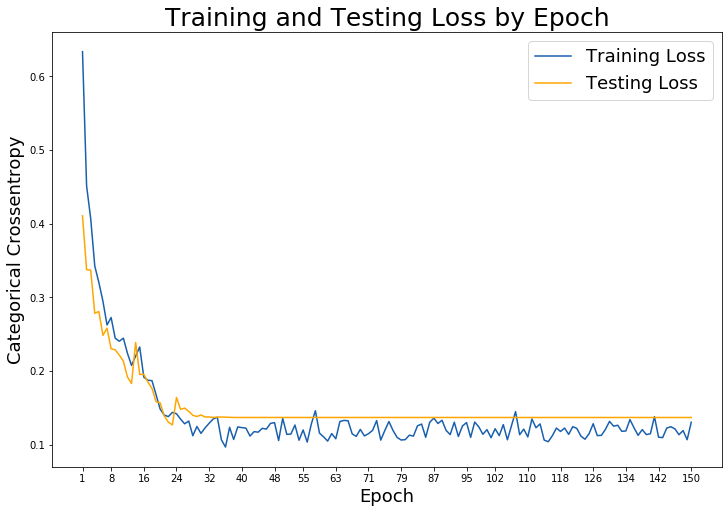

In [19]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

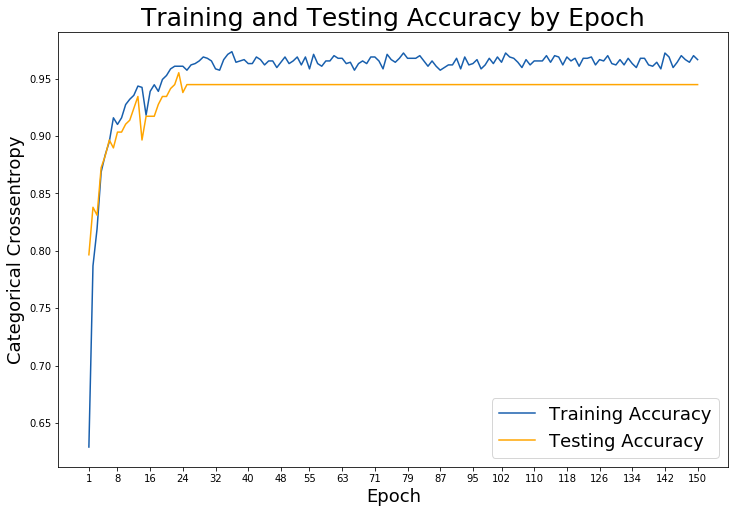

In [20]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train accuracy and accuracy loss over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

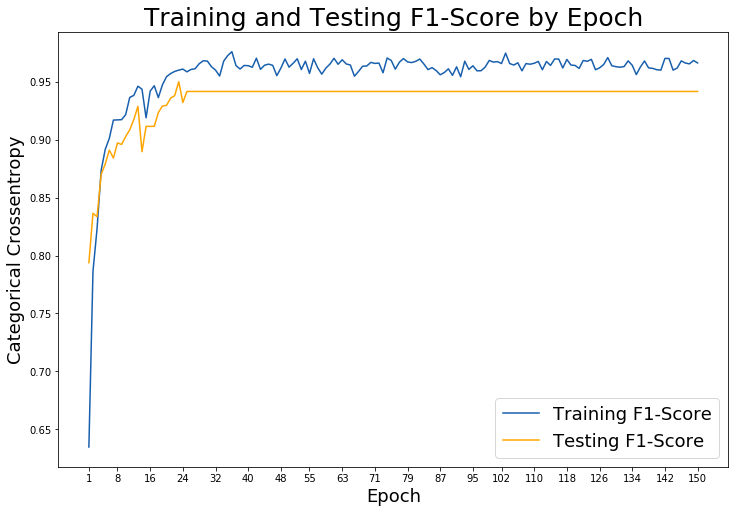

In [21]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train accuracy and accuracy loss over epochs.
train_loss = history.history['f1']
test_loss = history.history['val_f1']

# Set figure size.
plt.figure(figsize=(12, 8))

# Gaenerate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training F1-Score', color='#185fad')
plt.plot(test_loss, label='Testing F1-Score', color='orange')

# Set title
plt.title('Training and Testing F1-Score by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

In [22]:
test_master_w_predictions = pd.merge(test_master, predicted_player_nn, left_on='Player_name', right_on='Player_name')
test_master_w_predictions = pd.merge(test_master_w_predictions, predicted_player, left_on='Player_name', right_on='Player_name')
test_master_w_predictions.drop(columns=['lr_class', 'lr_class', 'tree_class', 'ada_class', 'knn_class', 'bag_class', 'svc', 'grad', 'forest_class', 'DRAFT_YEAR+1_x', 'DRAFT_YEAR+1_y'], inplace=True)
test_master_w_predictions.sort_values(by=['target','neural'], ascending=(False, False))

,Player_name,player_id,SEASON,Tm_x,Draft_team,Pk,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,College,Yrs,PTS,TRB,AST,FG%,3P%,FT%,PPG,RPG,APG,draft_round,target,neural,DRAFT_YEAR+1,tot
116,Domantas Sabonis,sabondo01,2018,IND,ORL,11.0,C,21,74,1810,17.5,0.567,0.056,0.339,10.4,25.2,17.8,12.7,1.1,1.6,15.3,22.1,2.5,2.2,4.7,0.126,-0.8,0.5,-0.3,0.8,Gonzaga University,3.0,2383.0,1550.0,445.0,0.513,0.343,0.722,10.4,6.8,1.9,1.0,1,1,2017.0,4
134,Montrezl Harrell,harremo01,2017,HOU,HOU,32.0,C,23,58,1064,19.2,0.662,0.020,0.351,8.3,14.2,11.2,9.6,0.9,3.2,9.9,17.6,3.1,1.0,4.1,0.183,0.8,0.2,0.9,0.8,University of Louisville,4.0,2864.0,1125.0,317.0,0.629,0.156,0.629,11.2,4.4,1.2,2.0,1,1,2016.0,7
140,Richaun Holmes,holmeri01,2017,PHI,PHI,37.0,C,23,57,1193,18.6,0.611,0.187,0.250,8.7,20.1,14.4,8.3,1.7,3.7,10.7,18.6,2.2,1.6,3.8,0.151,0.2,1.5,1.7,1.1,Bowling Green State University,4.0,1729.0,988.0,212.0,0.565,0.257,0.706,7.7,4.4,0.9,2.0,1,1,2016.0,6
154,Kristaps Porzingis,porzikr01,2017,NYK,NYK,4.0,PF,21,66,2164,17.4,0.546,0.319,0.256,5.5,18.2,11.8,7.3,1.1,4.9,9.7,24.3,2.4,2.1,4.5,0.100,0.2,0.0,0.2,1.2,NaN,3.0,3312.0,1317.0,248.0,0.437,0.361,0.804,17.8,7.1,1.3,1.0,1,1,2016.0,6
128,Devin Booker,bookede01,2017,PHO,PHO,13.0,SG,20,78,2730,14.6,0.531,0.283,0.308,1.8,8.3,5.0,16.3,1.3,0.6,12.9,28.6,1.3,0.6,2.0,0.035,0.4,-2.7,-2.3,-0.2,University of Kentucky,4.0,5820.0,945.0,1154.0,0.437,0.354,0.854,21.4,3.5,4.2,1.0,1,0,2016.0,5
0,Bam Adebayo,adebaba01,2019,MIA,MIA,14.0,C,21,82,1913,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,University of Kentucky,2.0,1206.0,978.0,285.0,0.550,0.136,0.728,8.0,6.5,1.9,1.0,0,1,2018.0,4
1,Jarrett Allen,allenja01,2019,BRK,BRK,22.0,C,20,80,2096,18.5,0.632,0.079,0.489,9.6,24.0,16.8,7.9,1.0,4.5,13.0,15.9,4.4,3.3,7.6,0.175,-0.7,3.2,2.5,2.4,University of Texas at Austin,2.0,1460.0,1060.0,159.0,0.590,0.183,0.732,9.6,7.0,1.0,1.0,0,1,2018.0,2
32,De'Aaron Fox,foxde01,2019,SAC,SAC,5.0,PG,21,81,2546,18.1,0.544,0.211,0.378,1.7,10.8,6.2,33.2,2.4,1.5,15.0,24.5,3.2,2.5,5.6,0.106,1.1,0.0,1.1,2.0,University of Kentucky,2.0,2243.0,508.0,910.0,0.439,0.345,0.725,14.6,3.3,5.9,1.0,0,1,2018.0,7
53,Lauri Markkanen,markkla01,2019,CHI,MIN,7.0,PF,21,52,1682,17.1,0.553,0.418,0.245,4.7,25.9,15.2,7.2,1.1,1.7,8.8,25.1,1.3,1.5,2.7,0.078,-0.3,-1.6,-1.9,0.0,University of Arizona,2.0,2007.0,978.0,154.0,0.432,0.362,0.859,16.7,8.2,1.3,1.0,0,1,2018.0,3
55,Donovan Mitchell,mitchdo01,2019,UTA,DEN,13.0,SG,22,77,2598,17.2,0.537,0.339,0.259,2.5,10.5,6.6,21.2,2.0,0.9,11.3,31.6,1.3,3.7,5.0,0.092,0.8,-0.2,0.6,1.7,University of Louisville,2.0,3445.0,612.0,613.0,0.434,0.351,0.805,22.1,3.9,3.9,1.0,0,1,2018.0,6


In [27]:
cd ..

/Users/pwalesdi/Desktop/GA/NBA_Player_Prediction


In [28]:
fig = px.scatter_3d(test_master_w_predictions, x='WS', y='VORP', z='RPG',
            color='neural', 
            hover_name='Player_name', 
            hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age'], 
            symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# fig.update_layout(scene=dict(xaxis=dict(range=[-15,10],),))
fig.update_layout(legend_orientation="h")
fig.show()
# plotly.offline.plot(fig, filename='html_files/ws_vorp_mp.html')

'html_files/ws_vorp_mp.html'

In [29]:
fig = px.scatter(test_master_w_predictions, x='VORP', y='WS',
            color='neural', hover_name='Player_name', hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age'], 
#             color_continuous_scale='rdbu',
            symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
# fig.update_xaxes(range=[-2, 7])
fig.update_layout(legend_orientation="h")
fig.show()
# plotly.offline.plot(fig, filename='html_files/ws_vorp.html')

'html_files/ws_vorp.html'

In [30]:
fig = px.scatter(test_master_w_predictions, x='TS%', y='USG%',
                 color='neural',
                 hover_name='Player_name',
                 hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age', 'RPG', 'VORP', 'WS'], 
                 color_continuous_scale=px.colors.diverging.PiYG,
                 symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(legend_orientation="h")
# fig.update_xaxes(range=[-2, 4.5])
fig.show()
# plotly.offline.plot(fig, filename='html_files/usg_ts%.html')

'html_files/usg_ts%.html'

In [31]:
fig = px.scatter(test_master_w_predictions, x='OWS', y='DWS',
                 color='neural',
                 hover_name='Player_name',
                 hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age', 'RPG', 'VORP', 'WS'], 
                 color_continuous_scale=px.colors.diverging.RdBu,
                 symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(legend_orientation="h")
# fig.update_xaxes(range=[-2, 4.5])
fig.show()
# plotly.offline.plot(fig, filename='html_files/ws_pk.html')

'html_files/ws_pk.html'

In [ ]:
test_master_w_predictions.corr()[['tot', 'neural']].sort_values('neural', ascending=False)

# values.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).head(77)